In [30]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from math import log2
%matplotlib inline

Loading Data and some utility functions

In [31]:
def load_clean_data():
    data = sio.loadmat('cleandata_students.mat')
    return data['x'], data['y']

def load_noisy_data():
    data = sio.loadmat('noisydata_students.mat')
    return data['x'], data['y']

In [32]:
EMOTIONS = ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']

def label_to_string(label):
    if label == 1:
        return 'anger'
    elif label == 2:
        return 'disgust'
    elif label == 3:
        return 'fear'
    elif label == 4:
        return 'happiness'
    elif label == 5:
        return 'sadness'
    elif label == 6:
        return 'surprise'
    else:
        return 'Unknown emotion label'

def string_to_label(s):
    if s == 'anger':
        return 1
    elif s == 'disgust':
        return 2
    elif s == 'fear':
        return 3
    elif s == 'happiness':
        return 4
    elif s == 'sadness':
        return 5
    elif s == 'surprise':
        return 6
    else:
        return -1

In [33]:
# turns targets into binary targets depending on the emotion
def to_binary_targets(targets, emotion):
    if isinstance(emotion, str):
        emotion = string_to_label(emotion)
    return targets == emotion

#Checking if binary targets contain of one value (point uniquely to answer)
def is_unique(bin_targets):
    if bin_targets.size == np.sum(bin_targets) or np.sum(bin_targets) == 0:
        return True
    return False

#Returning majority value of binary targets
def majority_value(bin_targets):
    if np.sum(bin_targets) > (bin_targets.size/2):
        return 1
    return 0

#Calculates recall on single tree
def calculate_recall(tree, examples, binary_targets):
    counter=0
    for index in range(0,examples.shape[0]):
        if test_one_tree(tree,examples[index],0)[0]==binary_targets[index]:
            counter+=1
    return counter/examples.shape[0]

Decision Tree class

In [34]:
class Tree:
    def __init__(self, op=None, kids=[], classification=None, pos=None, neg=None):
        self.op = op
        self.kids = kids
        self.classification = classification   # tree.class from the specs, but class is a keyword
        self.pos = pos
        self.neg = neg
    def is_leaf(self):
        return (self.classification != None)
    #Checks if a node is a parent to two leaves
    def is_leaves_parent(self):
        return self.kids[0] and self.kids[1] and self.kids[0].is_leaf() and self.kids[1].is_leaf()
    def count_leaves(self):
        if self.is_leaf():
            return 1
        else:
            return self.kids[0].count_leaves() + self.kids[1].count_leaves()

        
#Finds all nodes that are parents to two leaves
def find_all_parents(tree):
    L=[]
    if tree.is_leaf():
        return L
    elif tree.is_leaves_parent():
        L.append(tree)
        return L
    else:
        K = find_all_parents(tree.kids[0])
        M = find_all_parents(tree.kids[1])
        L.extend(K)
        L.extend(M)
        return L
        
def prune_tree(tree, validation_x, binary_targets):
    L = find_all_parents(tree)
    non_changed = 0
    for node in L:
        initial_recall = calculate_recall(tree, validation_x, binary_targets)
            
        temp = node.kids
        tempop = node.op
        node.op = None
        node.kids = []

        if node.pos > node.neg:
            node.classification = 1
        else:
            node.classification = 0
        end_recall = calculate_recall(tree, validation_x, binary_targets)

        if end_recall < initial_recall:
            node.classification = None
            node.kids = temp
            node.op = tempop
            non_changed += 1

    if non_changed == len(L):
        return tree
    return prune_tree(tree, validation_x, binary_targets)

In [35]:
#Calculating entropy
def entropy(p, n):
    from math import log
    if p+n == 0: return 0
    a = p/(p+n)
    b = n/(p+n)
    log2 = lambda x: log(x)/log(2)
    if a == 0 or b == 0:
        return 0
    return (-a*log2(a)-b*log2(b))


#Performing IG calculation for given attribute
def attribute_calculation(examples, index, binary_targets):
    p0, n0, p1, n1 = 0, 0, 0, 0
    for x in range(0, binary_targets.size):
        if binary_targets[x] == 0:
            if examples[x][index] == 1:
                n1 += 1
            else:
                n0 += 1
        else:
            if examples[x][index] == 1:
                p1 += 1
            else:
                p0 += 1

    p = np.sum(binary_targets)
    n = binary_targets.size-p

    e1 = entropy(p, n)
    e2 = entropy(p0, n0)
    e3 = entropy(p1, n1)

    remainder = (p0+n0)*e2/(p+n)+(p1+n1)*e3/(p+n)
    return e1 - remainder

#Choosing maximum IG
def choose_best_decision_attribute(examples, attributes, binary_targets, threshold=0):
    index = 0
    max_gain = attribute_calculation(examples, index, binary_targets)
    for x in range (0, attributes.size):
        value = attribute_calculation(examples, x, binary_targets)
        if max_gain < value:
            max_gain = value
            index = x
    if max_gain < threshold:
        return 0
    return attributes[index]

In [36]:
#Learning

def decision_tree_learning(examples, attributes, bin_targets, threshold=0):
    if examples.size == 0 or attributes.size == 0:
        return Tree(classification=int(majority_value(bin_targets)), pos=np.sum(bin_targets), neg=bin_targets.size-np.sum(bin_targets))
    elif is_unique(bin_targets):
        return Tree(classification=int(bin_targets[0]), pos=np.sum(bin_targets), neg=bin_targets.size-np.sum(bin_targets))
    else:
        best_attribute = choose_best_decision_attribute(examples, attributes, bin_targets, threshold)
        if best_attribute == 0:
            return Tree(classification=int(majority_value(bin_targets)), pos=np.sum(bin_targets), neg=bin_targets.size-np.sum(bin_targets))
        index = np.where(attributes==best_attribute)
        index = index[0][0]
        attributes = np.delete(attributes, index)

        ex1 = examples[examples[:,index]==1]
        ex0 = examples[examples[:,index]==0]

        bt1 = bin_targets[examples[:,index]==1]
        bt0 = bin_targets[examples[:,index]==0]

        ex1 = np.delete(ex1,index,axis=1)
        ex0 = np.delete(ex0,index,axis=1)

        t1 = decision_tree_learning(ex1, attributes, bt1, threshold)

        t0 = decision_tree_learning(ex0, attributes, bt0, threshold)

        return Tree(best_attribute, [t1,t0], pos=np.sum(bin_targets), neg=bin_targets.size-np.sum(bin_targets))

Visualization

In [37]:
def tree_width(node):
    if node.is_leaf():
        return 1
    return tree_width(node.kids[0]) + tree_width(node.kids[1])

def tree_height(node):
    if not node:
        return 0
    if not node.kids:
        return 1
    return max(tree_height(node.kids[0]), tree_height(node.kids[1])) + 1

def draw_node(draw, node, x, y):
    if node.is_leaf():
        draw.text((x-2,y), str(node.classification), (0,0,0))
    else:
        # false is the left branch
        wt = tree_width(node.kids[1]) * 20
        wf = tree_width(node.kids[0]) * 20
        left = x - (wt + wf)/2
        right = x + (wt + wf)/2
        draw.text((x-2,y-1), str(node.op), (0,0,0))
        draw.line((x,y,left+wf/2,y+30), fill=(255,0,0))
        draw.line((x,y,right-wt/2,y+30), fill=(255,0,0))
        draw_node(draw, node.kids[0], left+wf/2, y+30)
        draw_node(draw, node.kids[1], right-wt/2, y+30)

def visualize_tree(root_node):
    w = tree_width(root_node) * 20
    h = tree_height(root_node) * 30 + 10
    print(w, h)
    img = Image.new('RGB', (w,h), (255,255,255))
    draw = ImageDraw.Draw(img)
    draw_node(draw, root_node, w/2, 5)
    img.save('tree.jpg','JPEG')
    plt.imshow(img)
    plt.show()

Visualization example

['AU_1' 'AU_2' 'AU_3' 'AU_4' 'AU_5' 'AU_6' 'AU_7' 'AU_8' 'AU_9' 'AU_10'
 'AU_11' 'AU_12' 'AU_13' 'AU_14' 'AU_15' 'AU_16' 'AU_17' 'AU_18' 'AU_19'
 'AU_20' 'AU_21' 'AU_22' 'AU_23' 'AU_24' 'AU_25' 'AU_26' 'AU_27' 'AU_28'
 'AU_29' 'AU_30' 'AU_31' 'AU_32' 'AU_33' 'AU_34' 'AU_35' 'AU_36' 'AU_37'
 'AU_38' 'AU_39' 'AU_40' 'AU_41' 'AU_42' 'AU_43' 'AU_44' 'AU_45']
1300 370


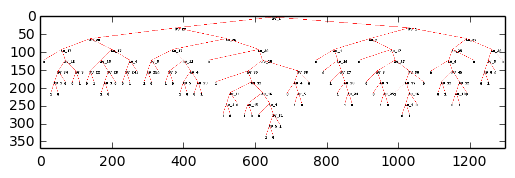

In [38]:
if __name__ == '__main__':
    emotion = 'surprise'
    examples, targets = load_clean_data()
    binary_targets = to_binary_targets(targets, emotion)
    attributes = np.array(['AU_' + str(x+1) for x in range(examples.shape[1])])
    print(attributes)
    tree = decision_tree_learning(examples, attributes, binary_targets)
    print(tree)
    visualize_tree(tree)

Cross-validation

In [27]:
#Tests one tree, returns depth of classification and classification
def test_one_tree(tree,features,depth):
    if tree.classification != None:
        return [tree.classification, depth+1]
    if features[tree.op-1]==1:
        return test_one_tree(tree.kids[0], features, depth+1)
    else:
        return test_one_tree(tree.kids[1], features, depth+1)

#Tests set of trained trees T on x2
def test_trees(T,x2):
    L=[]
    for index in range(0,x2.shape[0]):
        depths_pos = []
        out_pos = []
        depths_neg = []
        out_neg = []
        
        for t_num in range(0,T.size):
            test=test_one_tree(T[t_num],x2[index],0)
            if test[0]==1:
                depths_pos.append(test[1])
                out_pos.append(t_num+1)
            else:
                depths_neg.append(test[1])
                out_neg.append(t_num+1)
        
        if len(out_pos)==0:
            output = out_neg[depths_neg.index(max(depths_neg))]
        else:
            output = out_pos[depths_pos.index(min(depths_pos))]
            
        L.append(output)
    return L

In [28]:
#Creating confusion matrix

def confusion_matrix_10_cross(data, classification, threshold=0, prune=0):
    #Creating slices
    x_slices = np.vsplit(data[:900, :], 9)
    x_l_slice = data[900:, :]
    x_slices.append(x_l_slice)

    y_slices = np.vsplit(classification[:900], 9)
    y_l_slice = classification[900:]
    y_slices.append(y_l_slice)

    confusion_matrix = np.zeros((6,6), dtype=np.int)

    #i = ith cross-validation run
    for i in range(0,10):
        train_x = np.empty((0, 45), int)
        train_y = np.empty((0,1), int)

        for j in range (0,10):
            if j==i:
                test_x = x_slices[j]
                test_y = y_slices[j]
            else:
                train_x = np.concatenate((train_x, x_slices[j]), axis=0)
                train_y = np.concatenate((train_y, y_slices[j]), axis=0)

        attributes = np.arange(1, 46)

        #Training on train data
        L=[]

        for i in range(1,7):
            L.append(decision_tree_learning(train_x,attributes,to_binary_targets(train_y,i),threshold))
            if prune==1:
                L[i-1] = prune_tree(L[i-1], test_x,to_binary_targets(test_y,i))
        T = np.array(L)

        results = test_trees(T,test_x)

        for i in range(0, test_y.size):
            confusion_matrix[test_y[i] - 1, results[i] - 1]+=1

    return confusion_matrix

In [29]:
if __name__ == '__main__':
    x, y = load_clean_data()
    cm = confusion_matrix_10_cross(x,y,prune=1)
    print(cm)
    print((cm[0,0]+cm[1,1]+cm[2,2]+cm[3,3]+cm[4,4]+cm[5,5])/np.sum(cm))
    
    cm = confusion_matrix_10_cross(x,y,prune=0)
    print(cm)
    print((cm[0,0]+cm[1,1]+cm[2,2]+cm[3,3]+cm[4,4]+cm[5,5])/np.sum(cm))

[[ 97  16   6   2   8   3]
 [  8 175   0   5   9   1]
 [  3   4  90   4   2  16]
 [  3   8   1 198   1   5]
 [ 15  23   1   5  80   8]
 [  0   7   9   3   4 184]]
0.820717131474
[[ 90  19   4   4  13   2]
 [ 18 150   1  10  12   7]
 [  4   6  88   3   4  14]
 [  1  12   3 184  11   5]
 [ 25  16   7   8  72   4]
 [  3   5  15   6   9 169]]
0.75
